In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import kaydata
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm

In [3]:
# download dataset if its not present in the current directory
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

In [4]:
data = kaydata.DataLoader(combine=True)

## Training a neural network on image classification

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
X_train, y_train = next(iter(trainloader))
X_test, y_test = next(iter(testloader))

print("N Train: %s, N Test: %s" % (X_train.shape, X_test.shape))

N Train: torch.Size([50000, 3, 32, 32]), N Test: torch.Size([10000, 3, 32, 32])


In [5]:
# Use grey scale images
X_train = X_train.mean(dim=1).unsqueeze(1)
X_test  = X_test.mean(dim=1).unsqueeze(1)

print("N Train: %s, N Test: %s" % (X_train.shape, X_test.shape))

N Train: torch.Size([50000, 1, 32, 32]), N Test: torch.Size([10000, 1, 32, 32])


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 6)
        self.dropout = nn.Dropout(p = 0.55)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))        
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

network = Net().to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters())

In [7]:
class Net(nn.Module):    

    def __init__(self):
        """CNN Builder."""
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1)
        )
        
        self.conv3 = nn.Sequential(
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv3(self.conv2(self.conv1(x)))
        
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)

        return x
    
network = Net().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(network.parameters(), weight_decay=0.05)

In [8]:
train_data = X_train
train_label = y_train

test_data = X_test.to(device)
test_label = y_test.to(device)

In [9]:
n_epoch = 200
batch_size = 128

loss_tr = np.zeros(n_epoch)
loss_vl = np.zeros(n_epoch)

for epoch in tqdm(range(n_epoch)):    
    # SGD training
    network.train()
    shuffle_idx = np.random.permutation(train_data.shape[0])
    in_batches  = torch.split(train_data[shuffle_idx], batch_size)
    label_batches = torch.split(train_label[shuffle_idx], batch_size)

    loss_val = np.array([])
    for in_batch, label_batch in zip(in_batches, label_batches):
        optimizer.zero_grad()
        output = network.forward(in_batch.to(device))

        loss = loss_func(output, label_batch.to(device))
        loss.backward()        
        optimizer.step()
        
        loss_val = np.append(loss_val, loss.detach().cpu().numpy())        
        
    # evalulation
    network.eval()
    with torch.no_grad():        
        loss_tr[epoch] = np.mean(loss_val)

        output = network.forward(test_data)
        loss_vl[epoch] = loss_func(output, test_label).cpu()
        
        if epoch % 20 == 0:
            print("iter %d, train error: %.2f, test error: %.2f" % \
                 (epoch, loss_tr[epoch], loss_vl[epoch]))
        
network = network.eval()

  0%|          | 0/200 [00:00<?, ?it/s]

iter 0, train error: 1.59, test error: 1.20
iter 20, train error: 0.32, test error: 0.53
iter 40, train error: 0.18, test error: 0.57
iter 60, train error: 0.14, test error: 0.61
iter 80, train error: 0.12, test error: 0.69
iter 100, train error: 0.10, test error: 0.61
iter 120, train error: 0.10, test error: 0.66
iter 140, train error: 0.09, test error: 0.61
iter 160, train error: 0.09, test error: 0.66
iter 180, train error: 0.09, test error: 0.61


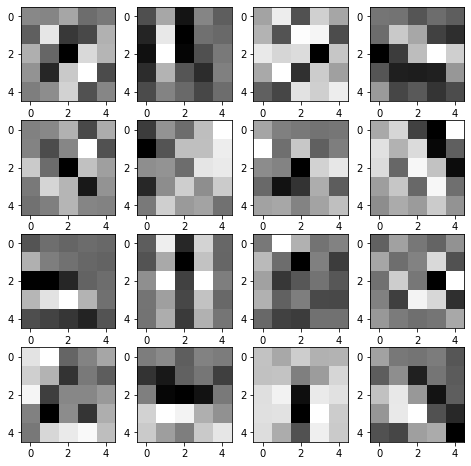

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
conv_weights = network.conv1.weight.detach().cpu().numpy()
for ax, idx in zip(axs.flat, range(16)):
    ax.imshow(conv_weights[idx, :].reshape(5, 5), cmap="gray")

plt.show()

In [10]:
network = network.cpu()
test_data = test_data.cpu()
test_label = test_label.cpu()

In [11]:
# Final accuracy on test set
test_output = network.forward(test_data)
loss_func(test_output, test_label).cpu()

output = torch.argmax(test_output.cpu(), dim=1).numpy()
label = test_label.cpu().numpy()
np.mean(output == label)

0.849

In [13]:
# Save trained network
torch.save(network.state_dict(), './simple_cnn.pt')

In [12]:
# Save trained network
torch.save(network.state_dict(), './large_cnn.pt')

## Use network to predict voxel responses

In [62]:
import cv2
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [94]:
edge_len = 32
targetSize = (edge_len, edge_len)
stimuli = data.stimuli
stimuli_ = np.zeros([stimuli.shape[0], edge_len, edge_len])
for idx in range(stimuli.shape[0]):
    stimuli_[idx, :] = cv2.resize(stimuli[idx, :], targetSize)
    
stimuli = stimuli_

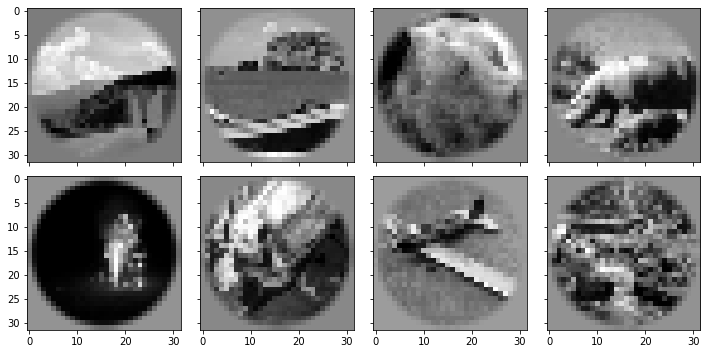

In [95]:
shuffle_idx = np.random.permutation(stimuli.shape[0])
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
for ax, im in zip(axs.flat, stimuli[shuffle_idx, :]):
    ax.imshow(im, cmap="gray")

fig.tight_layout()

### Smaller Network

In [ ]:
# Extract features
stim_input = torch.from_numpy(stimuli.astype(np.float32)).unsqueeze(1)

# cnn_feature = network.conv1(torch.from_numpy(stimuli.astype(np.float32)).unsqueeze(1))
cnn_feature = network.pool(F.relu(network.conv1(stim_input)))
cnn_feature = network.pool(F.relu(network.conv2(cnn_feature)))
cnn_feature = cnn_feature.view(cnn_feature.size(0), -1).detach().numpy()

cnn_feature.shape

In [ ]:
n_test = 100
n_val = 0
shuffle_idx = np.random.permutation(cnn_feature.shape[0])

feature_train, feature_test, feature_val = \
    kaydata.DataLoader.split_data(cnn_feature, n_test, n_val, shuffle_idx)

response_train, response_test, response_val = \
    kaydata.DataLoader.split_data(data.select_roi(['V1', 'V2']), n_test, n_val, shuffle_idx)


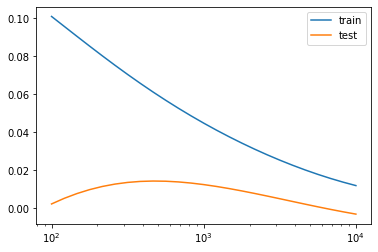

In [82]:
# Ridge Regression
alphas = np.logspace(2, 4, 25)

lm = linear_model.Ridge(alpha=1.0)

train_errors = list()
test_errors = list()

for alpha in alphas:
    lm.set_params(alpha=alpha)
    lm.fit(feature_train, response_train)
    train_errors.append(lm.score(feature_train, response_train))
    test_errors.append(lm.score(feature_test, response_test))
    
fig, ax = plt.subplots()

ax.semilogx(alphas, train_errors, label="train")
ax.semilogx(alphas, test_errors, label="test")
ax.legend()
plt.show()

### Large Network

#### Late Layers for V4?

In [93]:
lyrs = []
for idx, lyr in enumerate(network.fc_layer):
    lyrs.append(lyr)

In [94]:
lyrs

[Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=1024, bias=True),
 ReLU(inplace=True),
 Linear(in_features=1024, out_features=512, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=512, out_features=10, bias=True)]

In [96]:
stim_input = torch.from_numpy(stimuli.astype(np.float32)).unsqueeze(1)
features = network.conv3(network.conv2(network.conv1(stim_input)))
features = lyrs[1](features.view(features.size(0), -1)).detach().numpy()

features.shape

(1870, 1024)

In [108]:
n_test = 100
n_val = 0
shuffle_idx = np.random.permutation(features.shape[0])

feature_train, feature_test, feature_val = \
    kaydata.DataLoader.split_data(features, n_test, n_val, shuffle_idx)

response_train, response_test, response_val = \
    kaydata.DataLoader.split_data(data.select_roi(['V4', 'LatOcc']), n_test, n_val, shuffle_idx)

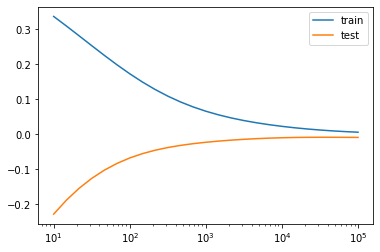

In [110]:
# Ridge Regression
alphas = np.logspace(1, 5, 25)

lm = linear_model.Ridge(alpha=1.0)

train_errors = list()
test_errors = list()

for alpha in alphas:
    lm.set_params(alpha=alpha)
    lm.fit(feature_train, response_train)
    train_errors.append(lm.score(feature_train, response_train))
    test_errors.append(lm.score(feature_test, response_test))
    
# Plot model performance
fig, ax = plt.subplots()

ax.semilogx(alphas, train_errors, label="train")
ax.semilogx(alphas, test_errors, label="test")
ax.legend()
plt.show()

#### V1, V2 Prediction

In [96]:
stim_input = torch.from_numpy(stimuli.astype(np.float32)).unsqueeze(1)
feature_1 = network.conv2(network.conv1(stim_input))
feature_1 = feature_1.view(feature_1.size(0), -1).detach().numpy()

feature_2 = network.conv3(network.conv2(network.conv1(stim_input)))
feature_2 = feature_2.view(feature_2.size(0), -1).detach().numpy()

features = np.concatenate((feature_1, feature_2), axis=1)
features.shape

(1870, 12288)

In [138]:
n_test = 100
n_val = 0
shuffle_idx = np.random.permutation(features.shape[0])

feature_train, feature_test, feature_val = \
    kaydata.DataLoader.split_data(features, n_test, n_val, shuffle_idx)

response_train, response_test, response_val = \
    kaydata.DataLoader.split_data(data.select_roi(['V1', 'V2']), n_test, n_val, shuffle_idx)

stim_train, stim_test, stim_val = \
    kaydata.DataLoader.split_data(data.stimuli, n_test, n_val, shuffle_idx)

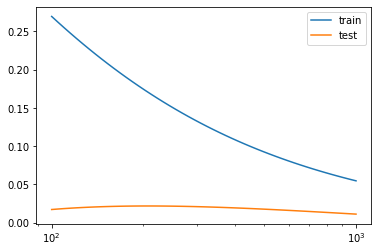

In [139]:
# Ridge Regression
alphas = np.logspace(2, 3, 50)

lm = linear_model.Ridge(alpha=1.0)

train_errors = list()
test_errors = list()

for alpha in alphas:
    lm.set_params(alpha=alpha)
    lm.fit(feature_train, response_train)
    train_errors.append(lm.score(feature_train, response_train))
    test_errors.append(lm.score(feature_test, response_test))
    
# Plot model performance
fig, ax = plt.subplots()

ax.semilogx(alphas, train_errors, label="train")
ax.semilogx(alphas, test_errors, label="test")
ax.legend()
plt.show()

In [191]:
alpha_star = alphas[np.argmax(test_errors)]
print(alpha_star)
print(np.max(test_errors))

lm = linear_model.Ridge(alpha=50)
lm.fit(feature_train, response_train)

pred = lm.predict(feature_train)

202.35896477251575
0.021865191526017264


666
0.4721940972252406


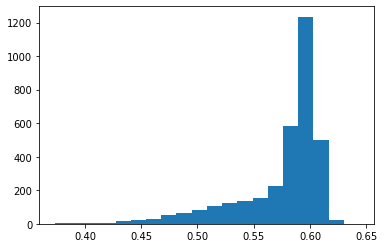

In [211]:
# Variable selection
error = np.mean((response_train - pred) ** 2, axis=0)

_ = plt.hist(error, bins=20)
select_idx = error < 0.55
print(np.sum(select_idx))
print(r2_score(response_train[:, select_idx], \
               pred[:, select_idx]))

In [212]:
pred_test = lm.predict(feature_test)
r2_score(response_test[:, select_idx], \
        pred_test[:, select_idx])

0.15285755012713328

### Plot results

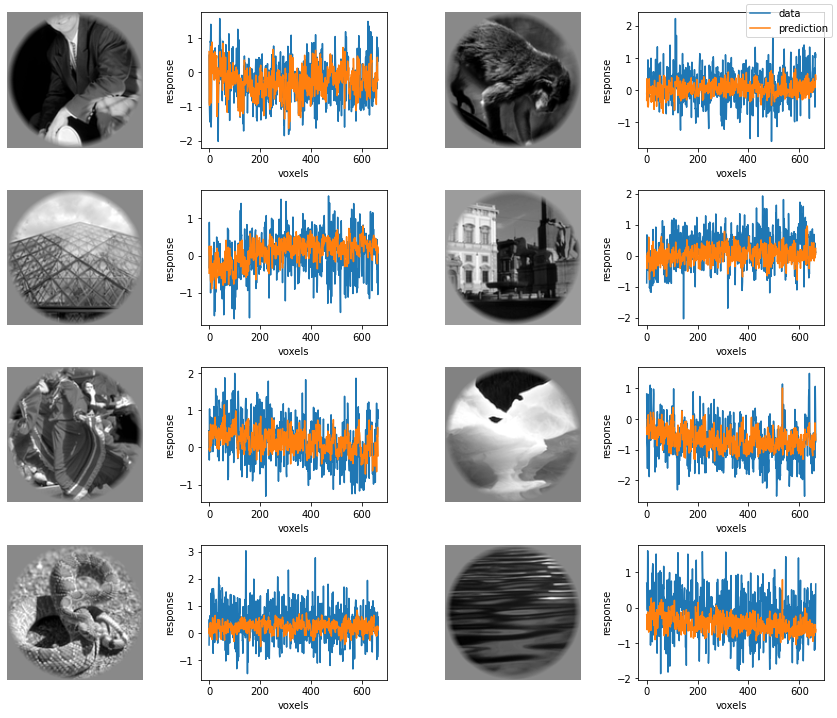

In [213]:
# Model prediction
error = np.mean((response_test[:, select_idx] - pred_test[:, select_idx]) ** 2, axis=1)
image_idx = np.argsort(error)[0:8]

fig, axs = plt.subplots(4, 4, figsize=(12, 10))
for idx in range(len(image_idx)):
    select = image_idx[idx]
    axs.flat[idx * 2].imshow(stim_test[select, :], cmap="gray")
    axs.flat[idx * 2].set_axis_off()    
    
    axs.flat[idx * 2 + 1].plot(response_test[select, select_idx], label='data')
    axs.flat[idx * 2 + 1].plot(pred_test[select, select_idx], label='prediction') 
    axs.flat[idx * 2 + 1].set_xlabel('voxels')
    axs.flat[idx * 2 + 1].set_ylabel('response')
    
handles, labels = axs.flat[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')    
fig.tight_layout()

In [219]:
# Decoding analysis
# feature_test, response_test, pred_test, select_idx
responses = response_test[:, select_idx]
predicts  = pred_test[:, select_idx]

results = np.zeros(responses.shape[0])
top_n = np.zeros(responses.shape[0])
for idx in range(responses.shape[0]):
    response = responses[idx, :]
    error = np.mean((predicts - response) ** 2, axis=1)
    decode = np.argmin(error)
        
    sort_idx = np.argsort(error)
        
    results[idx] = (idx == decode)
    
np.mean(results)

0.27

In [230]:
#top n
n = 1
top_n = np.zeros(responses.shape[0])
for idx in range(responses.shape[0]):
    response = responses[idx, :]
    
    error = np.mean((predicts - response) ** 2, axis=1)        
    sort_idx = np.argsort(error)[0:n]
    
    top_n[idx] = (idx in sort_idx)

np.mean(top_n)

0.27

In [252]:
acc_rate = []
guess_rate = []
for n in range(1, 10):
    top_n = np.zeros(responses.shape[0])

    for idx in range(responses.shape[0]):
        response = responses[idx, :]
    
        error = np.mean((predicts - response) ** 2, axis=1)        
        sort_idx = np.argsort(error)[0:n]
    
        top_n[idx] = (idx in sort_idx)
        
    acc_rate.append(np.mean(top_n))
    
    rate = 1.0
    for idx in range(1, n+1):
        rate *= (1 - 0.01 * idx)
        
    guess_rate.append(1 - rate)

Text(0, 0.5, 'accuracy')

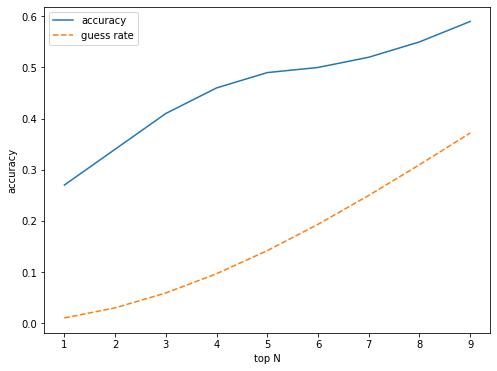

In [254]:
n = range(1, 10)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(n, acc_rate, label = 'accuracy')
ax.plot(n, guess_rate, '--', label = 'guess rate')
ax.legend()

ax.set_xlabel('top N')
ax.set_ylabel('accuracy')